# Building a Spam Filter using Naive - Bayes Algorithms

In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa

from sklearn.feature_extraction.text import CountVectorizer  ## BOW Model
from sklearn.feature_extraction.text import TfidfVectorizer  ## TFIDF Model

#for text - preprocessing
import re
import nltk
from nltk.stem.snowball import SnowballStemmer   
from nltk.corpus import stopwords

from sklearn.naive_bayes import BernoulliNB      #Bernoulli Naive - Bayes
from sklearn.naive_bayes import MultinomialNB    #Multinomial Naive - Bayes

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score

#Metrics to be used after preparing model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import glob  #To read multiple files in a given path
from sklearn.utils import shuffle  #To shuffle the dataframe

In [5]:
#Run this cell twice. Once to read ham emails second time to read spam emails
path = 'C:/Users/Pratheesh/Desktop/Desktop/Machine Learning/Spam Detection/Spam Dataset/Spam emails/*'
'''Setting the path to read Spam emails.
Put '*' at the end of the path to access files inside directory
To access Ham emails, change the directory to where it's located
'''
files = glob.glob(path)
spam_mail = []
#ham_mail = []                            #uncomment this line and comment the above line while reading ham_mails
for mails in files:                       #accessing all the txt files using a loop
    with open(mails) as f:                #opening each file
        for i,line in enumerate(f):
            if i>=2:        #reading from the third line as first two line contains 'Subject' which need not be included. 
                spam_mail.append(line)
                #ham_mail.append(line)    #uncomment this line and comment the above line while reading ham_mails

In [6]:
df1 = pd.DataFrame(spam_mail,columns = ['Mails'])  #Converting list to dataframe and labelling the column
df1['Label'] = 1  #Adding label as '1' for spam emails
df2 = pd.DataFrame(ham_mail, columns = ['Mails']) 
df2['Label'] = 0  #Adding label as '0' for ham emails
df = pd.concat((df1,df2),axis = 0)

In [7]:
df.shape

(962, 2)

In [8]:
conn = sqlite3.connect('mails.sqlite')    #Saving the changes made above into a new sqlite file
c=conn.cursor()
df.to_sql('Mails', conn, if_exists='replace')
conn.close()

In [9]:
conn = sqlite3.connect('mails.sqlite')  #Loading the sqlite file for future use
df = pd.read_sql_query("""SELECT * FROM Mails""", conn)
conn.close()
df.drop(['index'],axis = 1,inplace = True)
df.head()

,Mails,Label
0,* * * * * * * * * * * * * * * display box cred...,1
1,"dear nlpeople , ' m sure ' ll agree auto insur...",1
2,"want best hunt camp vacation life , felton 's ...",1
3,57 million email addresses $ 99 want money ? p...,1
4,attention ! warn ! adult ! warn ! adult ! unde...,1


In [10]:
stop = set(stopwords.words('english')) #set of stopwords

In [11]:
def cleanpunc(sentence):
    '''This function cleans all the punctuation or special characters from a given sentence'''
    cleaned = re.sub(r'[?|@|!|^|%|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|*]',r' ',cleaned)
    return  cleaned

In [12]:
def preprocessing(series):
    '''The function takes a Pandas Series object containing text in all the cells
       And performs following Preprocessing steps on each cell:
       1. Clean text from punctuations and special characters
       2. Retain only non-numeric Latin characters with lenght > 2
       3. Remove stopwords from the sentence
       4. Apply stemming to all the words in the sentence
       
       Return value:
       final_string - List of cleaned sentences
       '''
    
    i = 0
    str1=" "
    final_string = []    ## This list will contain cleaned sentences
    sno = SnowballStemmer("english")
    
    for sent in series.values:
        ## 
        filtered_sent = []
        sent = cleanpunc(sent)    ## Clean the punctuations and special characters
        ## Sentences are cleaned and words are handled individually
        for cleaned_words in sent.split():
            ## Only consider non-numeric words with length at least 3
            if((cleaned_words.isalpha()) and (len(cleaned_words) > 2)):
                ## Only consider words which are not stopwords and convert them to lowet case
                if(cleaned_words.lower() not in stop):
                    ## Apply snowball stemmer and add them to the filtered_sent list
                    s = (sno.stem(cleaned_words.lower()))#.encode('utf-8')
                    filtered_sent.append(s)    ## This contains all the cleaned words for a sentence

        ## Join back all the words belonging to the same sentence
        str1 = " ".join(filtered_sent)
        ## Finally add the cleaned sentence in the below list
        final_string.append(str1)
        i += 1
    return final_string

In [13]:
final_string = preprocessing(df['Mails'])  #Preprocessing the 'Mails' column in the DataFrame

In [14]:
df['Mails_Cleaned'] = final_string
df.head()

,Mails,Label,Mails_Cleaned
0,* * * * * * * * * * * * * * * display box cred...,1,display box credit applic need place small sto...
1,"dear nlpeople , ' m sure ' ll agree auto insur...",1,dear nlpeopl sure agre auto insur cost much ev...
2,"want best hunt camp vacation life , felton 's ...",1,want best hunt camp vacat life felton hunt cam...
3,57 million email addresses $ 99 want money ? p...,1,million email address want money put touch mil...
4,attention ! warn ! adult ! warn ! adult ! unde...,1,attent warn adult warn adult age interest sexu...


In [15]:
df = shuffle(df, random_state = 123)    #Shuffling the datafame

# Binary BoW for Bernoulli Naive - Bayes:

In [16]:
bow_vect = CountVectorizer(binary = True)   #binary = True for calculating binary BoW
bow = bow_vect.fit_transform(df["Mails_Cleaned"].values)

In [17]:
#Splitting vectors and labels
X = bow
y = df['Label'].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data


 The optimal value of alpha is0.1.


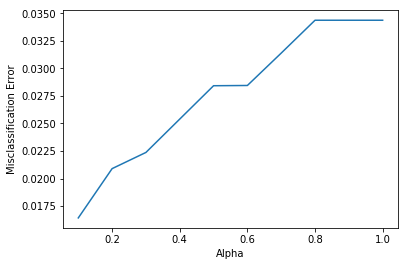

In [19]:
#Performing cross validation
alpha = np.linspace(0.1,1,10)  #Creates 10 divisions between 0.1 and 1 
cv_score = []  #Declaring an empty list to append all the cross - validation scores later

for a in alpha:     
    clf = BernoulliNB(alpha = a)  #Function to calculate Bernoulli NB probabilities
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())
    
MSE = [1-x for x in cv_score]

optimal_alpha = alpha[MSE.index(min(MSE))]   #Picking up optimal alpha value which has minimum Misclasification Error
print('\n The optimal value of alpha is{}.'.format(optimal_alpha))

#Plotting alpha vs Misclassification Error
plt.plot(alpha, MSE)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [20]:
#Testing the model for accuracy, confusion matrix and f-1 score with optimal alpha value
clf = BernoulliNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
print("The accuracy score is",acc)
print("The F1 score is",f1_score(y_test,y_pred))
print("The confusion matrix is:")
confusion_matrix(y_test,y_pred).T

The accuracy score is 97.5778546713
The F1 score is 0.976271186441
The confusion matrix is:


array([[138,   1],
       [  6, 144]], dtype=int64)

In [21]:
idx = (-clf.feature_log_prob_).argsort()[:2, :50]
print('Top 50 words in spam emails')
for i in idx[1]:
    print(bow_vect.get_feature_names()[i])
    
print('\n******************************\n')
print('Top 50 words in ham emails')
for i in idx[0]:
    print(bow_vect.get_feature_names()[i])

Top 50 words in spam emails
mail
free
pleas
one
com
list
receiv
http
day
address
inform
remov
send
want
need
money
best
order
check
name
offer
call
includ
mani
work
site
email
week
everi
internet
follow
servic
today
number
www
busi
market
first
even
click
thank
start
month
product
state
much
subject
avail
messag
interest

******************************

Top 50 words in ham emails
linguist
languag
univers
inform
one
edu
research
paper
includ
send
follow
interest
fax
present
address
http
english
work
pleas
word
call
form
name
two
develop
list
general
discuss
depart
number
refer
confer
relat
contact
www
studi
email
area
differ
first
post
avail
special
write
issu
institut
theori
case
possibl
topic


# BoW for Multinomial Naive - Bayes:

In [22]:
bow_vect = CountVectorizer()
bow = bow_vect.fit_transform(df["Mails_Cleaned"].values)

In [23]:
#Splitting the data into vectors and labels
X = bow     
y = df['Label'].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data into train and test sets


 The optimal value of alpha is0.1.


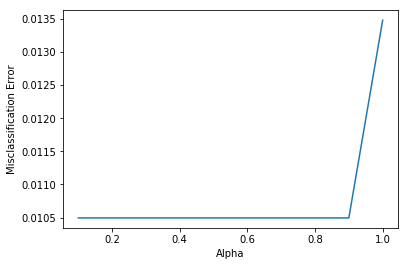

In [25]:
#Performing cross validation
alpha = np.linspace(0.1,1,10)  #Creates 10 divisions between 0.1 and 1 
cv_score = []  #Declaring an empty list to append all the cross - validation scores later

for a in alpha:     
    clf = MultinomialNB(alpha = a)  #Function to calculate Bernoulli NB probabilities
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())
    
MSE = [1-x for x in cv_score]

optimal_alpha = alpha[MSE.index(min(MSE))]   #Picking up optimal alpha value which has minimum Misclasification Error
print('\n The optimal value of alpha is{}.'.format(optimal_alpha))

#Plotting alpha vs Misclassification Error
plt.plot(alpha, MSE)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [26]:
#Testing the model for accuracy, confusion matrix and f-1 score with optimal alpha value
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
print("The accuracy is",acc)
print("The F1 score is",f1_score(y_test,y_pred))
print("The confusion matrix is")
confusion_matrix(y_test,y_pred).T

The accuracy is 97.9238754325
The F1 score is 0.979310344828
The confusion matrix is


array([[141,   3],
       [  3, 142]], dtype=int64)

# TF - IDF for Multinomial Naive - Bayes

In [27]:
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(df["Mails_Cleaned"].values)
tf_idf.shape

(962, 18988)

In [28]:
X = tf_idf
y = df['Label'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data


 The optimal value of alpha is0.4.


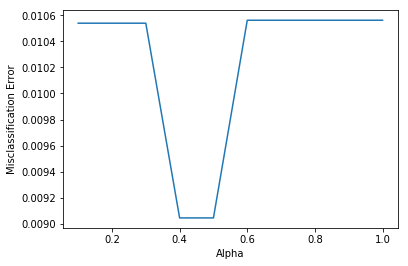

In [30]:
#Performing cross validation
alpha = np.linspace(0.1,1,10)  #Creates 10 divisions between 0.1 and 1 
cv_score = []  #Declaring an empty list to append all the cross - validation scores later

for a in alpha:     
    clf = MultinomialNB(alpha = a)  #Function to calculate Bernoulli NB probabilities
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())
    
MSE = [1-x for x in cv_score]

optimal_alpha = alpha[MSE.index(min(MSE))]   #Picking up optimal alpha value which has minimum Misclasification Error
print('\n The optimal value of alpha is{}.'.format(optimal_alpha))

#Plotting alpha vs Misclassification Error
plt.plot(alpha, MSE)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [31]:
#Testing the model for accuracy, confusion matrix and f-1 score with optimal alpha value
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
print("The accuracy is",acc)
print("The F1 score is",f1_score(y_test,y_pred))
print("The confusion matrix is")
confusion_matrix(y_test,y_pred).T

The accuracy is 97.9238754325
The F1 score is 0.979452054795
The confusion matrix is


array([[140,   2],
       [  4, 143]], dtype=int64)